## Please run under Windows 10 system

In [1]:
##要执行的我会在代码段前注释“第i步”
#第一步
import numpy
import pandas as pd
import datetime
import json
import os
import xlrd# 安装xlrd == 1.2.0 版本太高会出错
import numpy as np
import matplotlib.pyplot as plt
from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv
import copy
from skyfield.api import load, EarthSatellite
from skyfield.api import wgs84 as w84
from matplotlib.pyplot import MultipleLocator

### No need to run

In [2]:
def get_allfile(path):  # 获取所有文件
    all_file = []
    for f in os.listdir(path):  #listdir返回文件中所有目录
        f_name = os.path.join(path, f)
        all_file.append(f_name)
    return all_file

In [3]:
#第三步
#从TLE中提取相关字段到tle列表中
tle=[]
key_wanted=["NORAD_CAT_ID","OBJECT_NAME","EPOCH","INCLINATION","TLE_LINE1","TLE_LINE2","SEMIMAJOR_AXIS"]
tickets = r"/home/fit1-217/zhaow/laser/starlink(before 2022-7-20)/starlink"
all_file=get_allfile(tickets)  #tickets要获取文件夹名
for i in range(len(all_file)):
    filename=r"%s"%all_file[i]
    #print(filename)
    with open(filename) as f:
        temp=json.load(f)
        for item in temp:
            item["NORAD_CAT_ID"]=int(item["NORAD_CAT_ID"])
            item["SEMIMAJOR_AXIS"] = float(item["SEMIMAJOR_AXIS"])
            item["EPOCH"]=datetime.datetime.strptime('%s.%s'%(item["EPOCH"],item["EPOCH_MICROSECONDS"]),"%Y-%m-%d %H:%M:%S.%f")
            temp2=dict((key,value) for key, value in item.items() if key in key_wanted)
            tle.append(temp2)
df=pd.DataFrame(tle)

#提取到tle后按“NORAD_CAT_ID”分组，并按EPOCH的逆序排序
group = df.groupby("NORAD_CAT_ID")
starlink_dict = {}
for dfGroupBy in group:
    df_dict_key = dfGroupBy[0]
    df_dict_value = pd.DataFrame(dfGroupBy[1])
    starlink_dict[df_dict_key] = df_dict_value.sort_values(by='EPOCH',ascending=True)
#print(starlink_dict['STARLINK-3282'])

In [5]:
def cal_vel(sat_id):
    sat_df1 = starlink_dict[sat_id]
    sat_df1 = sat_df1[(sat_df1['EPOCH'] >= datetime.datetime(2022,3,30)) & (sat_df1['EPOCH'] <= datetime.datetime(2022,7,1))]
    sat_v1 = {}
    sat_p1 = {}
    for i in range(len(sat_df1)):
        if((sat_df1.iloc[i,2] < datetime.datetime(2022,4,1))):
            if((sat_df1.iloc[i + 1,2] < datetime.datetime(2022,4,1))):
                continue
            elif((sat_df1.iloc[i + 1,2] >= datetime.datetime(2022,4,1))):
                tle_line1 = sat_df1.iloc[i,4]
                tle_line2 = sat_df1.iloc[i,5]
                epoch = sat_df1.iloc[i,2]
                start_time = datetime.datetime(2022,4,1)
        else:
            tle_line1 = sat_df1.iloc[i,4]
            tle_line2 = sat_df1.iloc[i,5]
            epoch = sat_df1.iloc[i,2]
            start_time = sat_df1.iloc[i,2].round('1min')
        if(i < len(sat_df1) - 1):
            if(sat_df1.iloc[i + 1,2].second >= 30):
                end_time = sat_df1.iloc[i + 1,2].round('1min')
            else:
                end_time = sat_df1.iloc[i + 1,2].round('1min') + datetime.timedelta(minutes=1)
        else:
            end_time = datetime.datetime(2022,7,1)
        # print('start time is',start_time)
        # print('stop time is',end_time)
        time_delta = int(((end_time - start_time).total_seconds()) / 60)
        #print('epoch is ',epoch)
        for j in range(time_delta):
            tle_epoch = start_time + datetime.timedelta(minutes=j)
            year = tle_epoch.year
            month = tle_epoch.month
            day = tle_epoch.day
            hour = tle_epoch.hour
            minute = tle_epoch.minute
            second = tle_epoch.second

            ts = load.timescale()
            sat = EarthSatellite(tle_line1,tle_line2,None,ts)
            t = ts.utc(year,month,day,hour,minute,second)
            geocentric = sat.at(t)
            if(tle_epoch in sat_v1.keys()):continue
            #print(tle_epoch)
            sat_v1[tle_epoch] = geocentric.velocity.km_per_s
            sat_p1[tle_epoch] = geocentric.position.km
    return sat_v1,sat_p1

In [ ]:
unnecessary_neigh = np.load(r'/home/fit1-217/zhaow/laser/unnecessary_neigh.npy',allow_pickle=True).item()

In [7]:
sat_v = {}
sat_p = {}
for key in unnecessary_neigh:
    if(key != '45568'):continue
    print(key)
    if(key not in sat_v.keys()):
        sat_v1,sat_p1 = cal_vel(int(key))
        sat_v[key] = sat_v1
        sat_p[key] = sat_p1
    for item in unnecessary_neigh[key]:
        if(item not in sat_v.keys()):
            sat_v1,sat_p1 = cal_vel(int(item))
            sat_v[item] = sat_v1
            sat_p[item] = sat_p1
    # relative_vel = {}
    # for item in unnecessary_neigh[key]:
    #     relative_vel[item] = []
    #     if(item in task_maneuver):continue
    #     else:
    #         for keytime in sat_v[key].keys():
    #             #print(sat_v[key][keytime][0],sat_v[item][keytime][0])
    #             delta_v = np.sqrt(np.square(sat_v[key][keytime][0] - sat_v[item][keytime][0]) + np.square(sat_v[key][keytime][1] - sat_v[item][keytime][1]) + np.square(sat_v[key][keytime][2] - sat_v[item][keytime][2]))
    #             relative_vel[item].append(((2*delta_v) / 299792.458) * 1000000)
    # np.save('/home/fit1-217/zhaow/laser/data/%s.npy'% key,relative_vel)

45568


In [13]:
relative_vel = {}
key = '45568'
for item in unnecessary_neigh[key]:
    relative_vel[item] = []
    for keytime in sat_v[key].keys():
        #print(sat_v[key][keytime][0],sat_v[item][keytime][0])
        r1 = np.array(sat_p[key][keytime])
        r2 = np.array(sat_p[item][keytime])
        v1 = np.array(sat_v[key][keytime])
        v2 = np.array(sat_v[item][keytime])
        r = r2 - r1
        r_abs = np.sqrt(sum(np.square(r)))
        r_hat = r / r_abs
        v = v2 - v1
        v_X = np.cross(v,r_hat)
        v_abs = np.sqrt(sum(np.square(v_X)))
        paa = ((2 * v_abs) / 299792.458) * 1000000
        relative_vel[item].append(paa)
        # print('r2 r1 is ',r2,r1)
        # print('r is ',r)
        # print('r_abs is ',r_abs)
        # print('r_hat is ',r_hat)
        # print('v2 v1 is ',v2,v1)
        # print('v is ',v)
        # print('v_X is ',v_X)
        # print('v_abs is ',v_abs)
        # print('paa is ',paa)

### Start from this line

In [2]:
relative_vel = np.load('./data/relative_vel.npy',allow_pickle=True).item()
time = np.load('./data/time.npy',allow_pickle=True).tolist()

<Figure size 432x288 with 0 Axes>

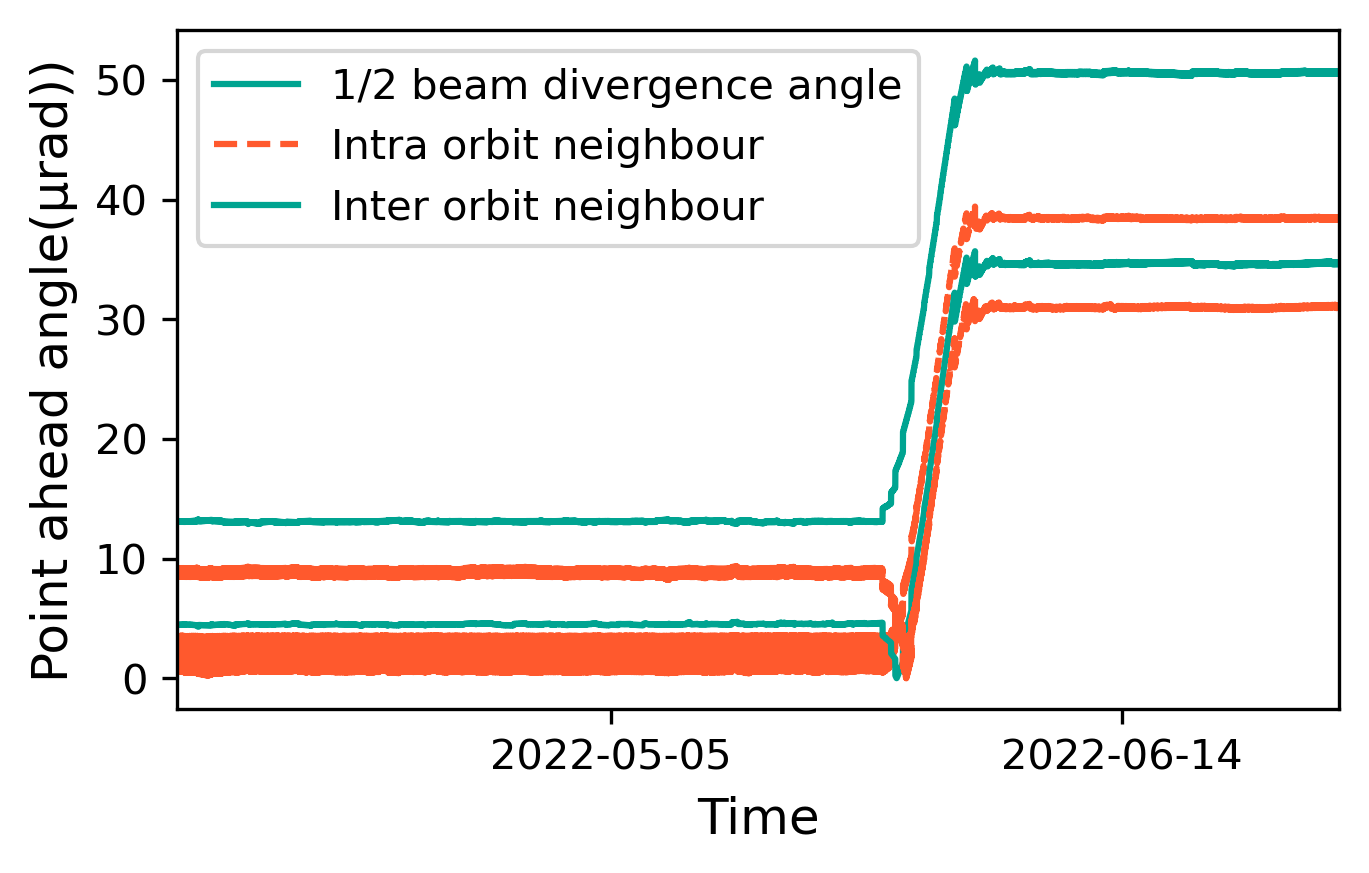

In [5]:
plt.figure(1)
fig = plt.figure(figsize=(5,3),dpi = 300)
x_major_locator=MultipleLocator(40)
ax = fig.subplots(1,1,sharex = True)
plt.hlines(35,19078.450034722224, 19178.549270833333,color = 'r',linestyles=':')
plt.plot(time,relative_vel['45084'],color = "#00A491")
plt.plot(time,relative_vel['46711'],'--',color = "#FF592D")
plt.plot(time,relative_vel['45088'],color = "#00A491")
plt.plot(time,relative_vel['47787'],'--',color = "#FF592D")
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim([datetime.datetime(2022,4,1),datetime.datetime(2022,7,1)])
plt.legend(['1/2 beam divergence angle','Intra orbit neighbour','Inter orbit neighbour'])
plt.xlabel('Time',fontsize = 12)
plt.ylabel('Point ahead angle(μrad))',fontsize = 12)
plt.savefig('Figure25b.pdf',bbox_inches='tight',pad_inches = 0.01)